In [2]:
from os.path import isfile
from statistics import mode

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sksurv.linear_model import CoxnetSurvivalAnalysis

# Data load

In [5]:
clients = pd.read_csv("data/clients.csv")
train_info = pd.read_csv("data/train.csv")
report_dates = pd.read_csv("data/report_dates.csv")
sample_submit_naive = pd.read_csv("data/sample_submit_naive.csv")
sample = pd.read_csv("data/sample_submit_naive.csv")

transactions = pd.read_csv("data/transactions.csv")
transactions = transactions.merge(clients[["user_id", "report"]]).merge(report_dates)

# Feature engineering from transaction history

## Reciving the start and end dates of each report

In [3]:
report_dates_full = (
    transactions.groupby("report")[["transaction_dttm", "report_dt"]]
    .agg({"transaction_dttm": ["min", "max"], "report_dt": "first"})
    .rename(
        columns={
            "min": "report_start_dt",
            "max": "report_finish_dt",
            "first": "report_dt",
        }
    )
    .droplevel(0, axis=1)
    .reset_index()
)
report_dates_full["report_start_dt"] = report_dates_full["report_start_dt"].replace(
    to_replace=r"\d{2}:\d{2}:\d{2}$", value="09:00:00", regex=True
)
report_dates_full["report_finish_dt"] = report_dates_full["report_finish_dt"].replace(
    to_replace=r"\d{2}:\d{2}:\d{2}$", value="21:00:00", regex=True
)
report_dates_full["report_duration_hours"] = (
    pd.to_datetime(report_dates_full["report_finish_dt"])
    - pd.to_datetime(report_dates_full["report_start_dt"])
).apply(lambda x: x.total_seconds() // 3600)
report_dates_full

,report,report_start_dt,report_finish_dt,report_dt,report_duration_hours
0,1,2021-10-20 09:00:00,2022-04-20 21:00:00,2022-07-31 03:00:00,4380.0
1,2,2021-11-20 09:00:00,2022-05-21 21:00:00,2022-08-31 03:00:00,4380.0
2,3,2021-12-20 09:00:00,2022-06-20 21:00:00,2022-09-30 03:00:00,4380.0
3,4,2022-01-20 09:00:00,2022-07-21 21:00:00,2022-10-31 03:00:00,4380.0
4,5,2022-02-19 09:00:00,2022-08-20 21:00:00,2022-11-30 03:00:00,4380.0
5,6,2022-03-22 09:00:00,2022-09-20 21:00:00,2022-12-31 03:00:00,4380.0
6,7,2022-04-22 09:00:00,2022-10-21 21:00:00,2023-01-31 03:00:00,4380.0
7,8,2022-05-20 09:00:00,2022-11-18 21:00:00,2023-02-28 03:00:00,4380.0
8,9,2022-06-20 09:00:00,2022-12-19 21:00:00,2023-03-31 03:00:00,4380.0
9,10,2022-07-20 09:00:00,2023-01-18 21:00:00,2023-04-30 03:00:00,4380.0


In [5]:
transactions = transactions.merge(report_dates_full).merge(train_info, how="left")
transactions["last_transaction_dttm"] = transactions.groupby("user_id")["transaction_dttm"].shift(
    1
)
transactions["since_last_transaction_hours"] = (
    pd.to_datetime(transactions["transaction_dttm"])
    - pd.to_datetime(transactions["last_transaction_dttm"])
).apply(lambda x: x.total_seconds() / 3600)

transactions["since_report_started"] = (
    pd.to_datetime(transactions["transaction_dttm"])
    - pd.to_datetime(transactions["report_start_dt"])
).apply(lambda x: x.total_seconds() / 3600)

transactions["day_diff"] = (
    pd.to_datetime(transactions["report_dt"])
    - pd.to_datetime(transactions["transaction_dttm"])
).dt.days
transactions

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,report,report_dt,report_start_dt,report_finish_dt,report_duration_hours,last_transaction_dttm,target,time,since_last_transaction_hours,since_report_started,day_diff
0,3,3,1,-183.883957,2022-01-28 12:05:33,2,2022-08-31 03:00:00,2021-11-20 09:00:00,2022-05-21 21:00:00,4380.0,NaN,0.0,77.0,NaN,1659.092500,214
1,3,3,1,-3206.437012,2022-01-28 12:52:30,2,2022-08-31 03:00:00,2021-11-20 09:00:00,2022-05-21 21:00:00,4380.0,2022-01-28 12:05:33,0.0,77.0,0.782500,1659.875000,214
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2,2022-08-31 03:00:00,2021-11-20 09:00:00,2022-05-21 21:00:00,4380.0,2022-01-28 12:52:30,0.0,77.0,457.890556,2117.765556,195
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2,2022-08-31 03:00:00,2021-11-20 09:00:00,2022-05-21 21:00:00,4380.0,2022-02-16 14:45:56,0.0,77.0,509.209167,2626.974722,174
4,3,0,1,5297.908691,2022-03-12 18:11:31,2,2022-08-31 03:00:00,2021-11-20 09:00:00,2022-05-21 21:00:00,4380.0,2022-03-09 19:58:29,0.0,77.0,70.217222,2697.191944,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13075018,549549,1,1,-385.725952,2022-10-18 19:46:01,7,2023-01-31 03:00:00,2022-04-22 09:00:00,2022-10-21 21:00:00,4380.0,2022-10-17 19:25:37,NaN,NaN,24.340000,4306.766944,104
13075019,549549,11,1,-27.274351,2022-10-18 20:52:33,7,2023-01-31 03:00:00,2022-04-22 09:00:00,2022-10-21 21:00:00,4380.0,2022-10-18 19:46:01,NaN,NaN,1.108889,4307.875833,104
13075020,549549,1,1,-616.261047,2022-10-20 15:14:24,7,2023-01-31 03:00:00,2022-04-22 09:00:00,2022-10-21 21:00:00,4380.0,2022-10-18 20:52:33,NaN,NaN,42.364167,4350.240000,102
13075021,549549,3,1,-3083.803711,2022-10-20 17:05:15,7,2023-01-31 03:00:00,2022-04-22 09:00:00,2022-10-21 21:00:00,4380.0,2022-10-20 15:14:24,NaN,NaN,1.847500,4352.087500,102


## Random users activity

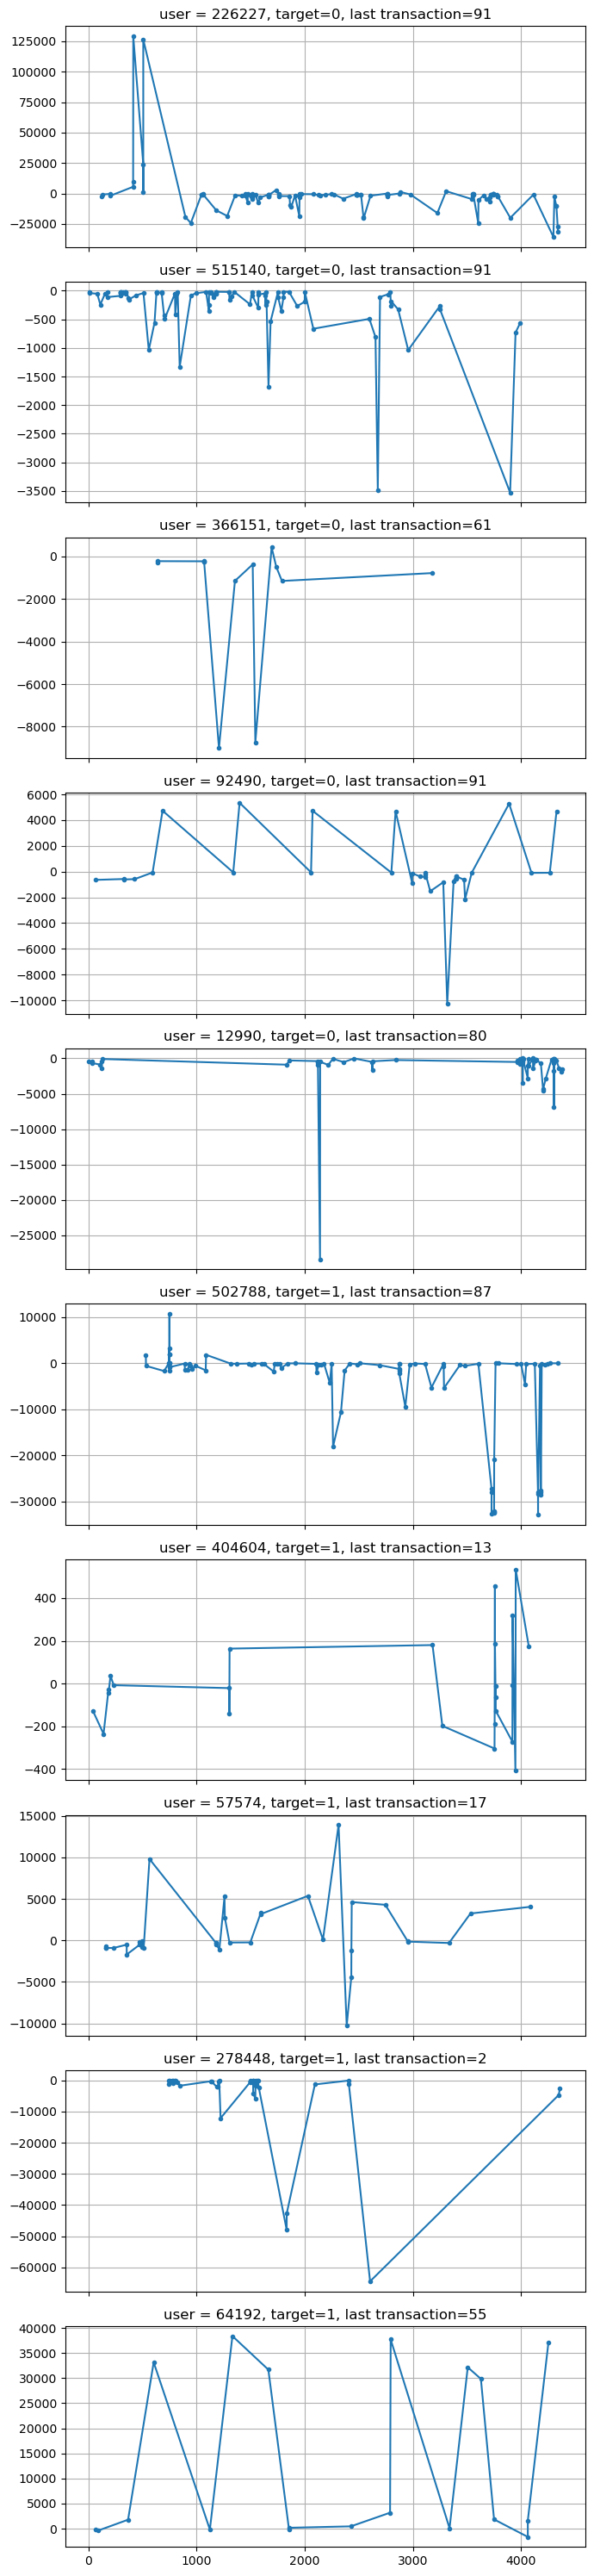

In [6]:
USERS_AMOUNT = 5
sampled_users_print = np.concatenate(
    [
        np.random.choice(
            train_info[train_info["target"] == 0]["user_id"].unique(), USERS_AMOUNT
        ),
        np.random.choice(
            train_info[train_info["target"] == 1]["user_id"].unique(), USERS_AMOUNT
        ),
    ]
)
fig, axs = plt.subplots(
    USERS_AMOUNT * 2, 1, tight_layout=True, figsize=(7, 30), sharex=True
)
for i, user_id_i in enumerate(sampled_users_print):
    axs[i].plot(
        transactions[transactions["user_id"] == user_id_i]["since_report_started"],
        transactions[transactions["user_id"] == user_id_i]["transaction_amt"],
        marker=".",
    )
    axs[i].grid()
    axs[i].set_title(
        "user = {}, target={}, last transaction={}".format(
            user_id_i,
            train_info[train_info["user_id"] == user_id_i].iloc[0][1],
            train_info[train_info["user_id"] == user_id_i].iloc[0][2],
        )
    )

## Feature engineering from the full transactions history

In [4]:
%%time

if isfile("data/features_full_report.csv"):
    print("Read features from csv")
    features = pd.read_csv("data/features_full_report.csv")
else:
    print("Create features from transaction history")
    REPORT_DURATION_HOURS = 4380
    transactions["abs_tr"] = abs(transactions["transaction_amt"])
    features = transactions.groupby("user_id").agg(
        unique_mcc_codes=("mcc_code", "nunique"),
        before_first_transaction_hours=("since_report_started", "first"),
        # before_last_transaction_hours=("since_report_started", "last"),
        mean_time_diff_tr=("since_last_transaction_hours", "mean"),
        med_time_diff_tr=("since_last_transaction_hours", "median"),
        std_time_diff_tr=("since_last_transaction_hours", "std"),
        qnt10_time_diff_tr=("since_last_transaction_hours", lambda x: x.quantile(0.1)),
        qnt90_time_diff_tr=("since_last_transaction_hours", lambda x: x.quantile(0.9)),
        # count_tr_per_hour=("transaction_amt", lambda x: x.count() / REPORT_DURATION_HOURS),  # 182.5 days
        # sum_tr=("transaction_amt", "sum"),
        mean_tr=("transaction_amt", "mean"),
        med_tr=("transaction_amt", "median"),
        std_tr=("transaction_amt", "std"),
        # count_tr=("transaction_amt", "count"),
        qnt10_tr=("transaction_amt", lambda x: x.quantile(0.1)),
        qnt90_tr=("transaction_amt", lambda x: x.quantile(0.9)),
        # sum_abs_tr=("abs_tr", "sum"),
        mean_abs_tr=("abs_tr", "mean"),
        med_abs_tr=("abs_tr", "median"),
        std_abs_tr=("abs_tr", "std"),
        qnt10_abs_tr=("abs_tr", lambda x: x.quantile(0.1)),
        qnt90_abs_tr=("abs_tr", lambda x: x.quantile(0.9)),
        sum_pos_tr=("transaction_amt", lambda x: sum(x[x > 0])),
        mean_pos_tr=("transaction_amt", lambda x: x[x > 0].mean()),
        med_pos_tr=("transaction_amt", lambda x: x[x > 0].median()),
        std_pos_tr=("transaction_amt", lambda x: x[x > 0].std()),
        count_pos_tr=("transaction_amt", lambda x: x[x > 0].count()),
        qnt10_pos_tr=("transaction_amt", lambda x: x[x > 0].quantile(0.1)),
        qnt90_pos_tr=("transaction_amt", lambda x: x[x > 0].quantile(0.9)),
        sum_neg_tr=("transaction_amt", lambda x: sum(x[x < 0])),
        mean_neg_tr=("transaction_amt", lambda x: x[x < 0].mean()),
        med_neg_tr=("transaction_amt", lambda x: x[x < 0].median()),
        std_neg_tr=("transaction_amt", lambda x: x[x < 0].std()),
        count_neg_tr=("transaction_amt", lambda x: x[x < 0].count()),
        qnt10_neg_tr=("transaction_amt", lambda x: x[x < 0].quantile(0.1)),
        qnt90_neg_tr=("transaction_amt", lambda x: x[x < 0].quantile(0.9)),
        life_hours=("since_report_started", lambda x: max(x) - min(x)),
        unique_days=("day_diff", "nunique"),
        last_tr_amt=("transaction_amt", "last"),
        last2_tr_amt=("transaction_amt", lambda x: x.tail(2).iloc[0]),
        last3_tr_amt=("transaction_amt", lambda x: x.tail(3).iloc[0]),
        mode_mcc_code=("mcc_code", lambda x: mode(x)),
        mode_currency=("currency_rk", lambda x: mode(x)),
    )
    features.to_csv("data/features_full_report.csv")
features.head()

Read features from csv
CPU times: total: 656 ms
Wall time: 735 ms


,user_id,unique_mcc_codes,before_first_transaction_hours,before_last_transaction_hours,mean_time_diff_tr,median_time_diff_tr,std_time_diff_tr,qnt10_time_diff_tr,qnt90_time_diff_tr,count_tr_per_hour,...,count_neg_tr,qnt10_neg_tr,qnt90_neg_tr,life_hours,unique_days,last_tr_amt,last2_tr_amt,last3_tr_amt,mode_mcc_code,mode_currency
0,3,4,1659.092500,4211.662500,255.257000,180.762917,257.561152,0.387083,530.549778,0.002511,...,4,-112250.203906,-1090.649873,2552.570000,8,104011.960938,5386.999023,28335.613281,0,1
1,9,22,3.900278,4355.042222,48.889235,21.943889,90.306736,0.385167,143.458389,0.020548,...,90,-4270.121582,-219.823502,4351.141944,54,-4246.083008,-3042.217285,-3792.205322,1,1
2,13,4,27.211111,4067.815000,192.409709,194.235000,174.587197,0.640278,419.083333,0.005023,...,14,-24566.357031,-9605.339648,4040.603889,18,-16394.193359,10805.421875,-10642.210938,3,1
3,37,28,0.335000,4296.875833,13.683251,4.894861,21.276777,0.300639,29.353333,0.071918,...,313,-1971.609570,-76.457050,4296.540833,130,-2030.448853,-219.175751,-457.468903,2,1
4,41,5,654.722500,4331.693611,245.131407,55.409167,313.107900,0.577444,699.259667,0.003653,...,16,-12649.590820,-531.802338,3676.971111,12,-6226.305176,-1819.140625,-11565.626953,3,1


## Feature engineering from the transactions history over the last month

In [5]:
%%time

if isfile("data/features_last_month.csv"):
    print("Read features from csv")
    features_last_month = pd.read_csv("data/features_last_month.csv")
else:
    print("Create features from transaction history")
    TWO_MONTHS_HOURS = 60 * 24
    features_last_month = (
        transactions[transactions["since_report_started"] > TWO_MONTHS_HOURS]
        .groupby("user_id")
        .agg(
            unique_mcc_codes_last_month=("mcc_code", "nunique"),
            mean_time_diff_tr_last_month=("since_last_transaction_hours", "mean"),
            med_time_diff_tr_last_month=("since_last_transaction_hours", "median"),
            std_time_diff_tr_last_month=("since_last_transaction_hours", "std"),
            qnt10_time_diff_tr_last_month=(
                "since_last_transaction_hours",
                lambda x: x.quantile(0.1),
            ),
            qnt90_time_diff_tr_last_month=(
                "since_last_transaction_hours",
                lambda x: x.quantile(0.9),
            ),
            # count_tr_per_hour_last_month=("transaction_amt", lambda x: x.count() / 4380),
            # sum_tr_last_month=("transaction_amt", "sum"),
            mean_tr_last_month=("transaction_amt", "mean"),
            med_tr_last_month=("transaction_amt", "median"),
            std_tr_last_month=("transaction_amt", "std"),
            # count_tr_last_month=("transaction_amt", "count"),
            qnt10_tr_last_month=("transaction_amt", lambda x: x.quantile(0.1)),
            qnt90_tr_last_month=("transaction_amt", lambda x: x.quantile(0.9)),
            # sum_abs_tr_last_month=("abs_tr", "sum"),
            mean_abs_tr_last_month=("abs_tr", "mean"),
            med_abs_tr_last_month=("abs_tr", "median"),
            std_abs_tr_last_month=("abs_tr", "std"),
            qnt10_abs_tr_last_month=("abs_tr", lambda x: x.quantile(0.1)),
            qnt90_abs_tr_last_month=("abs_tr", lambda x: x.quantile(0.9)),
            sum_pos_tr_last_month=("transaction_amt", lambda x: sum(x[x > 0])),
            mean_pos_tr_last_month=("transaction_amt", lambda x: x[x > 0].mean()),
            med_pos_tr_last_month=("transaction_amt", lambda x: x[x > 0].median()),
            std_pos_tr_last_month=("transaction_amt", lambda x: x[x > 0].std()),
            count_pos_tr_last_month=("transaction_amt", lambda x: x[x > 0].count()),
            qnt10_pos_tr_last_month=("transaction_amt", lambda x: x[x > 0].quantile(0.1)),
            qnt90_pos_tr_last_month=("transaction_amt", lambda x: x[x > 0].quantile(0.9)),
            sum_neg_tr_last_month=("transaction_amt", lambda x: sum(x[x < 0])),
            mean_neg_tr_last_month=("transaction_amt", lambda x: x[x < 0].mean()),
            med_neg_tr_last_month=("transaction_amt", lambda x: x[x < 0].median()),
            std_neg_tr_last_month=("transaction_amt", lambda x: x[x < 0].std()),
            count_neg_tr_last_month=("transaction_amt", lambda x: x[x < 0].count()),
            qnt10_neg_tr_last_month=("transaction_amt", lambda x: x[x < 0].quantile(0.1)),
            qnt90_neg_tr_last_month=("transaction_amt", lambda x: x[x < 0].quantile(0.9)),
            # life_hours_last_month=("since_report_started", lambda x: max(x) - min(x)),
            unique_days_last_month=("day_diff", "nunique"),
            # last_tr_amt_last_month=("transaction_amt", "last"),
            # last2_tr_amt_last_month=("transaction_amt", lambda x: x.tail(2).iloc[0]),
            # last3_tr_amt_last_month=("transaction_amt", lambda x: x.tail(3).iloc[0]),
            mode_mcc_code_last_month=("mcc_code", lambda x: mode(x)),
            mode_currency_last_month=("currency_rk", lambda x: mode(x)),
        )
    )
    features_last_month.to_csv("data/features_last_month.csv")
features_last_month.head()

Read features from csv
CPU times: total: 500 ms
Wall time: 525 ms


,user_id,unique_mcc_codes_last_month,mean_time_diff_tr_last_month,median_time_diff_tr_last_month,std_time_diff_tr_last_month,qnt10_time_diff_tr_last_month,qnt90_time_diff_tr_last_month,count_tr_per_hour_last_month,sum_tr_last_month,mean_tr_last_month,...,count_neg_tr_last_month,qnt10_neg_tr_last_month,qnt90_neg_tr_last_month,life_hours_last_month,unique_days_last_month,last_tr_amt_last_month,last2_tr_amt_last_month,last3_tr_amt_last_month,mode_mcc_code_last_month,mode_currency_last_month
0,3,4,255.257000,180.762917,257.561152,0.387083,530.549778,0.002511,13706.416641,1246.037876,...,4,-112250.203906,-1090.649873,2552.570000,8,104011.960938,5386.999023,28335.613281,0,1
1,9,18,50.263611,16.667639,101.341917,0.270444,139.848472,0.013242,-285803.556637,-4927.647528,...,58,-4406.690967,-261.388271,2887.135278,30,-4246.083008,-3042.217285,-3792.205322,1,1
2,13,4,198.114623,101.979722,199.273074,0.506306,465.298500,0.003196,-64021.636475,-4572.974034,...,9,-31468.371094,-9532.141016,2388.082778,11,-16394.193359,10805.421875,-10642.210938,3,1
3,37,24,11.724339,4.605972,20.429329,0.305694,25.201111,0.056164,-210867.111567,-857.183380,...,244,-958.055890,-74.579157,2849.711389,91,-2030.448853,-219.175751,-457.468903,2,1
4,41,5,209.209583,51.930972,291.089801,0.492667,667.822833,0.003196,-80192.609283,-5728.043520,...,14,-11964.531250,-498.798224,2836.300278,10,-6226.305176,-1819.140625,-11565.626953,3,1


In [6]:
# features_last_month = pd.read_csv("data/features_last_month.csv")
# features = pd.read_csv("data/features_full_report.csv")
features_full = features.merge(features_last_month, on="user_id")#.drop(
#     columns=[
#         "count_tr_per_hour",
#         "sum_tr",
#         "sum_abs_tr",
#         "count_tr",
#         "count_tr_per_hour_last_month",
#         "sum_tr_last_month",
#         "sum_abs_tr_last_month",
#         "count_tr_last_month",
#         "life_hours_last_month",
#         "last_tr_amt_last_month",
#         "last2_tr_amt_last_month",
#         "last3_tr_amt_last_month",
#         "before_last_transaction_hours"
#     ]
# ).rename(columns={"median_time_diff_tr_last_month": "med_time_diff_tr_last_month", "median_time_diff_tr": "med_time_diff_tr"})
features_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         96000 non-null  int64  
 1   unique_mcc_codes                96000 non-null  int64  
 2   before_first_transaction_hours  96000 non-null  float64
 3   mean_time_diff_tr               96000 non-null  float64
 4   med_time_diff_tr                96000 non-null  float64
 5   std_time_diff_tr                96000 non-null  float64
 6   qnt10_time_diff_tr              96000 non-null  float64
 7   qnt90_time_diff_tr              96000 non-null  float64
 8   mean_tr                         96000 non-null  float64
 9   med_tr                          96000 non-null  float64
 10  std_tr                          96000 non-null  float64
 11  qnt10_tr                        96000 non-null  float64
 12  qnt90_tr                        

## Additional features engeneering

In [7]:
features_full["count_tr_last_month_perc"] = np.square(
    (
        features_full["count_pos_tr_last_month"]
        + features_full["count_neg_tr_last_month"]
    )
    / (features_full["count_pos_tr"] + features_full["count_neg_tr"])
)

# Data preprocessing

## Features grouping

In [18]:
features_full.columns

Index(['user_id', 'unique_mcc_codes', 'before_first_transaction_hours',
       'mean_time_diff_tr', 'med_time_diff_tr', 'std_time_diff_tr',
       'qnt10_time_diff_tr', 'qnt90_time_diff_tr', 'mean_tr', 'med_tr',
       'std_tr', 'qnt10_tr', 'qnt90_tr', 'mean_abs_tr', 'med_abs_tr',
       'std_abs_tr', 'qnt10_abs_tr', 'qnt90_abs_tr', 'sum_pos_tr',
       'mean_pos_tr', 'med_pos_tr', 'std_pos_tr', 'count_pos_tr',
       'qnt10_pos_tr', 'qnt90_pos_tr', 'sum_neg_tr', 'mean_neg_tr',
       'med_neg_tr', 'std_neg_tr', 'count_neg_tr', 'qnt10_neg_tr',
       'qnt90_neg_tr', 'life_hours', 'unique_days', 'last_tr_amt',
       'last2_tr_amt', 'last3_tr_amt', 'mode_mcc_code', 'mode_currency',
       'unique_mcc_codes_last_month', 'mean_time_diff_tr_last_month',
       'med_time_diff_tr_last_month', 'std_time_diff_tr_last_month',
       'qnt10_time_diff_tr_last_month', 'qnt90_time_diff_tr_last_month',
       'mean_tr_last_month', 'med_tr_last_month', 'std_tr_last_month',
       'qnt10_tr_last_month

In [9]:
comparable_features = [
    "mean_tr",
    "med_tr",
    "std_tr",
    "qnt10_tr",
    "qnt90_tr",
    "mean_abs_tr",
    "med_abs_tr",
    "std_abs_tr",
    "qnt10_abs_tr",
    "qnt90_abs_tr",
    "sum_neg_tr",
    "count_neg_tr",
    "mean_neg_tr",
    "med_neg_tr",
    "std_neg_tr",
    "qnt10_neg_tr",
    "qnt90_neg_tr",
    "sum_pos_tr",
    "count_pos_tr",
    "mean_pos_tr",
    "med_pos_tr",
    "std_pos_tr",
    "qnt10_pos_tr",
    "qnt90_pos_tr",
    "mean_time_diff_tr",
    "med_time_diff_tr",
    "std_time_diff_tr",
    "qnt10_time_diff_tr",
    "qnt90_time_diff_tr",
    "unique_mcc_codes",
    "unique_days",
]
cat_features = [
    "mode_mcc_code",
    "mode_mcc_code_last_month",
    "mode_currency",
    "mode_currency_last_month",
]
other_features = [
    "last_tr_amt",
    "last2_tr_amt",
    "last3_tr_amt",
    "before_first_transaction_hours",
    "life_hours",
    "count_tr_last_month_perc",
]
check_sets_equality = set(features_full.columns) == (
    set(comparable_features)
    | set([_ + "_last_month" for _ in comparable_features])
    | set(cat_features)
    | set(other_features)
    | {"user_id"}
)
check_duplicates = len(features_full.columns) == (
    2 * len(comparable_features) + len(cat_features) + len(other_features) + 1
)
print(
    "All features selected: {}\nNo duplicated features: {}".format(
        check_sets_equality, check_duplicates
    )
)

All features selected: True
No duplicated features: True


## Histograms

### Features from the full report

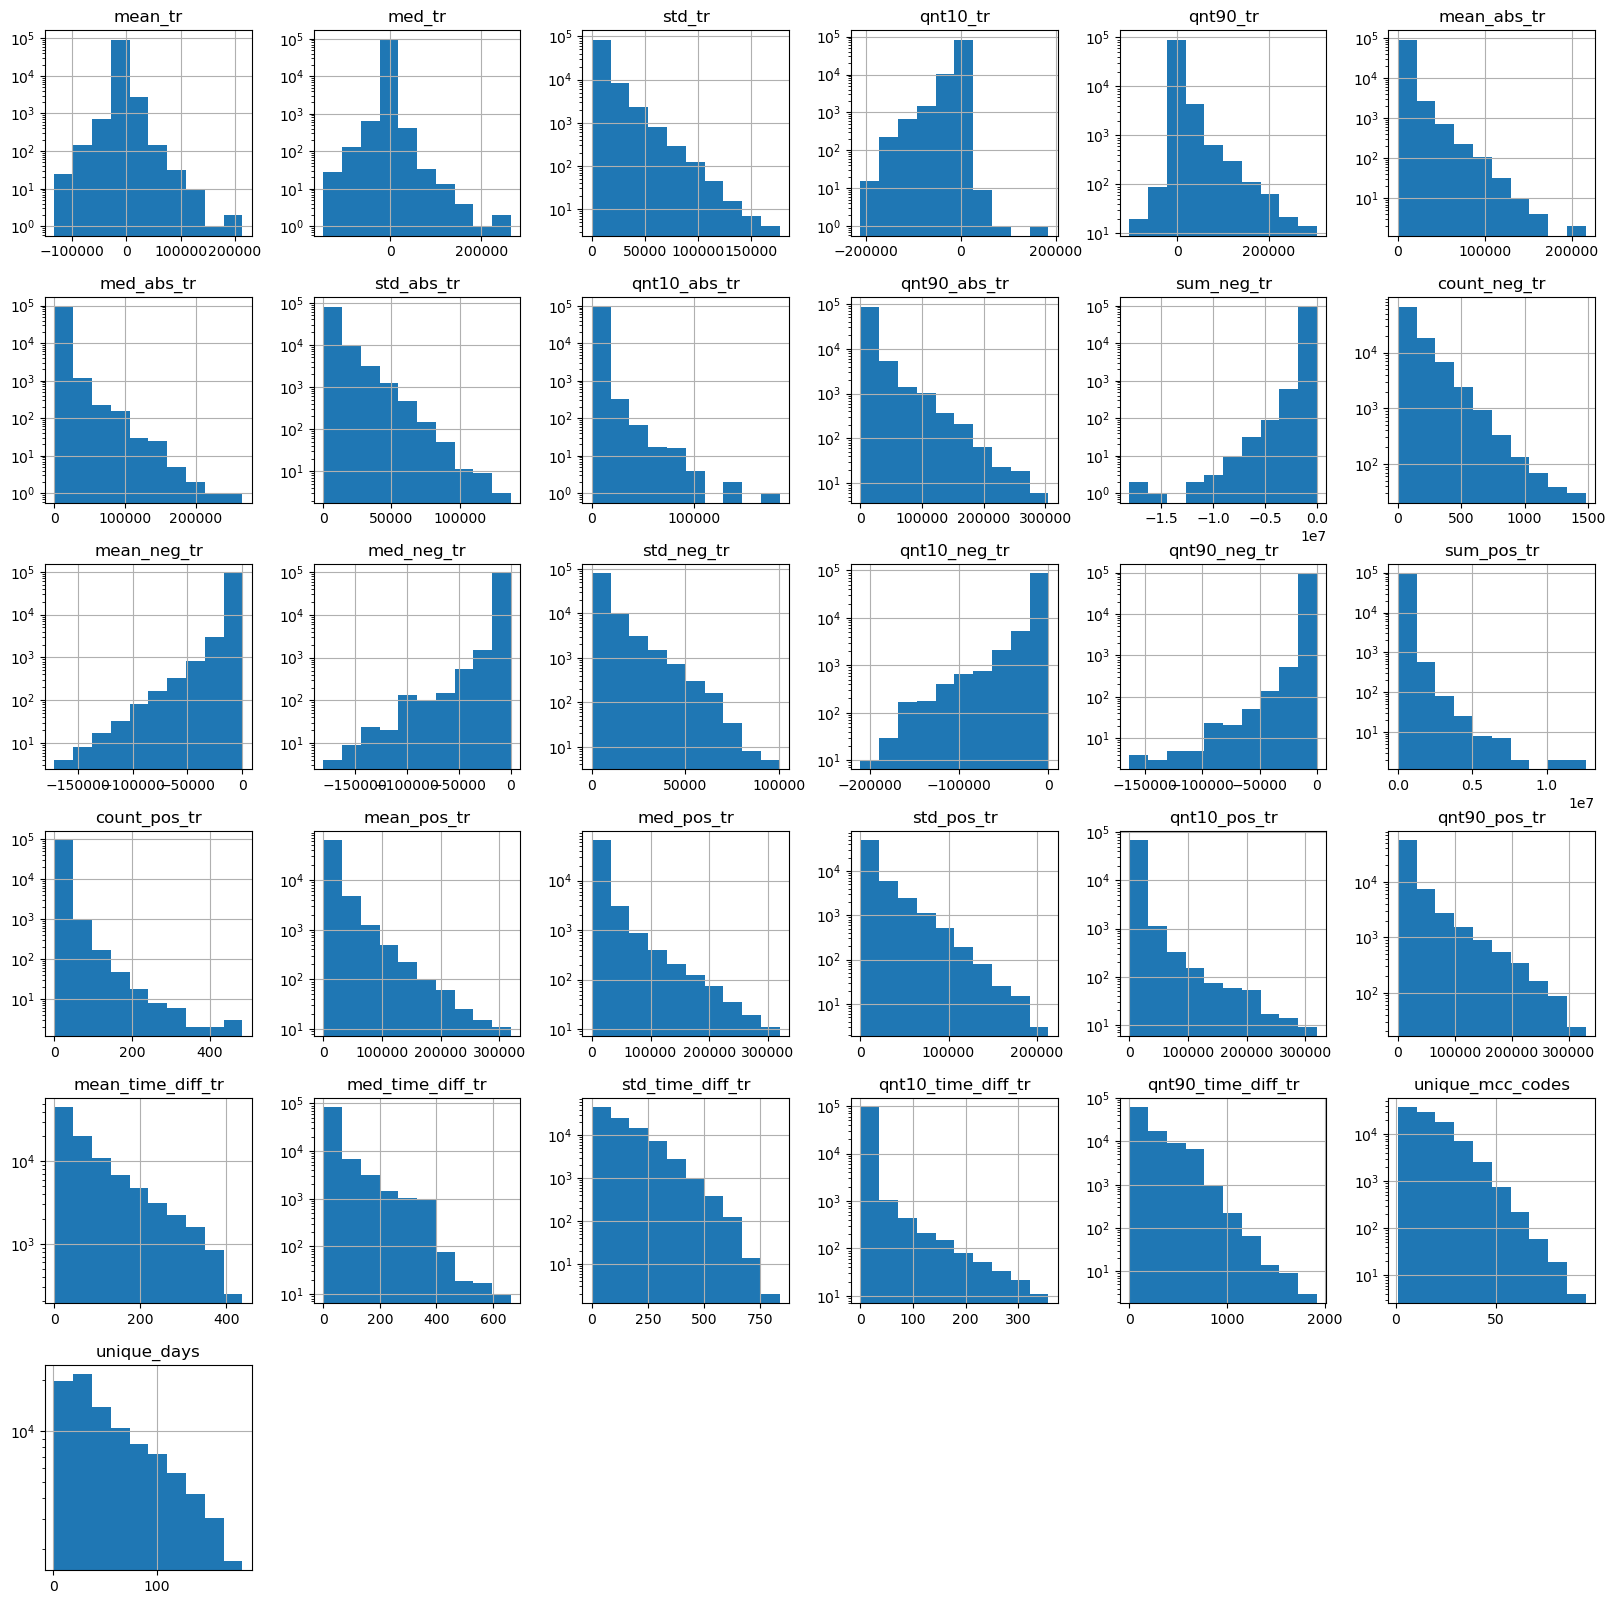

In [21]:
features_full[comparable_features].hist(figsize=(20,20),log=True);

### Features from the report for the last month

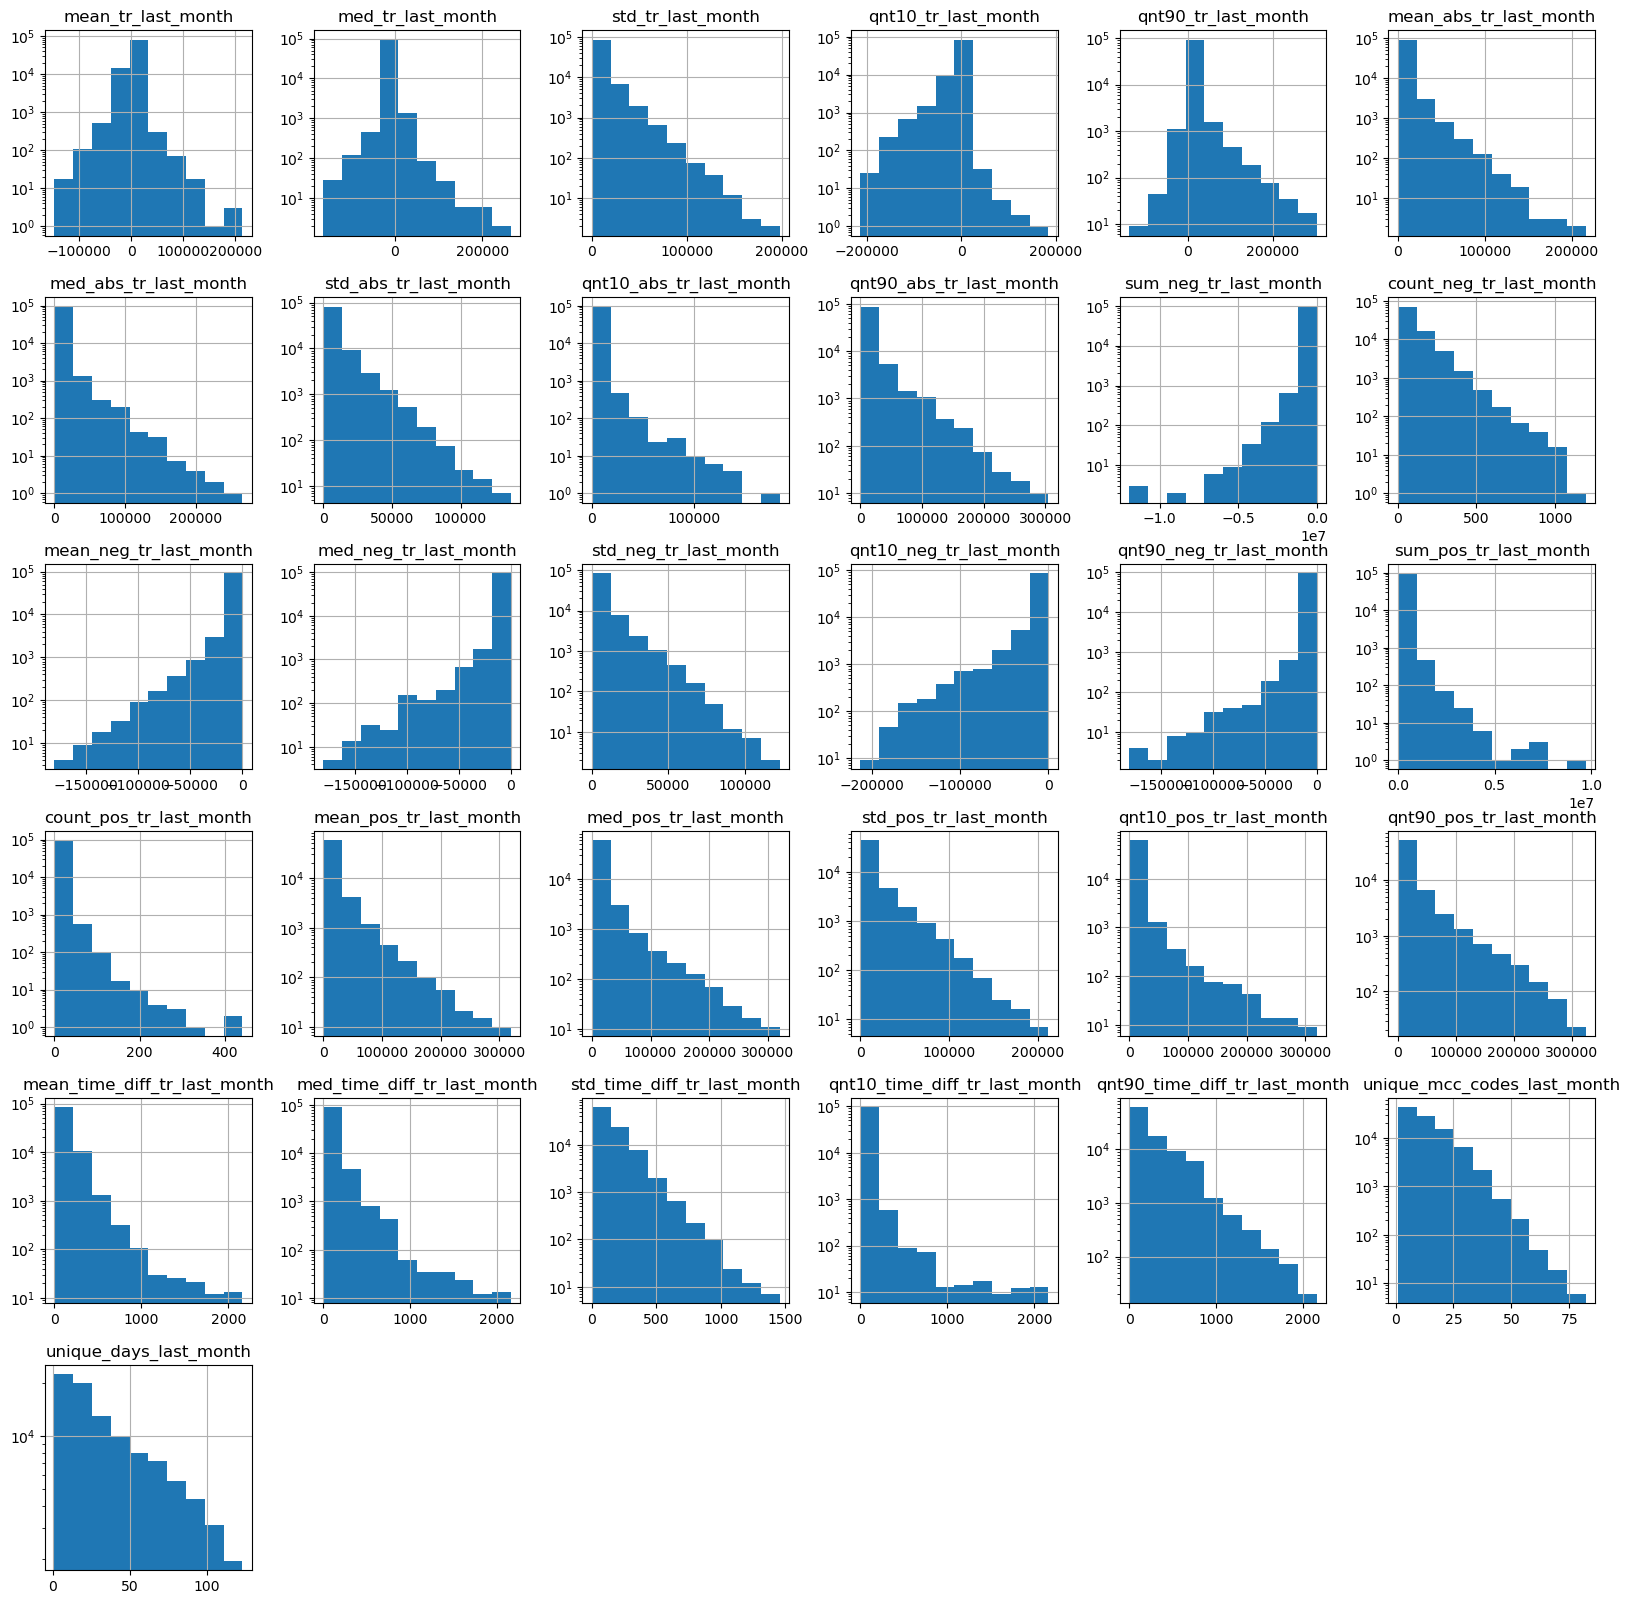

In [51]:
features_full[[_ + "_last_month" for _ in comparable_features]].hist(figsize=(20,20),log=True);

### Other features

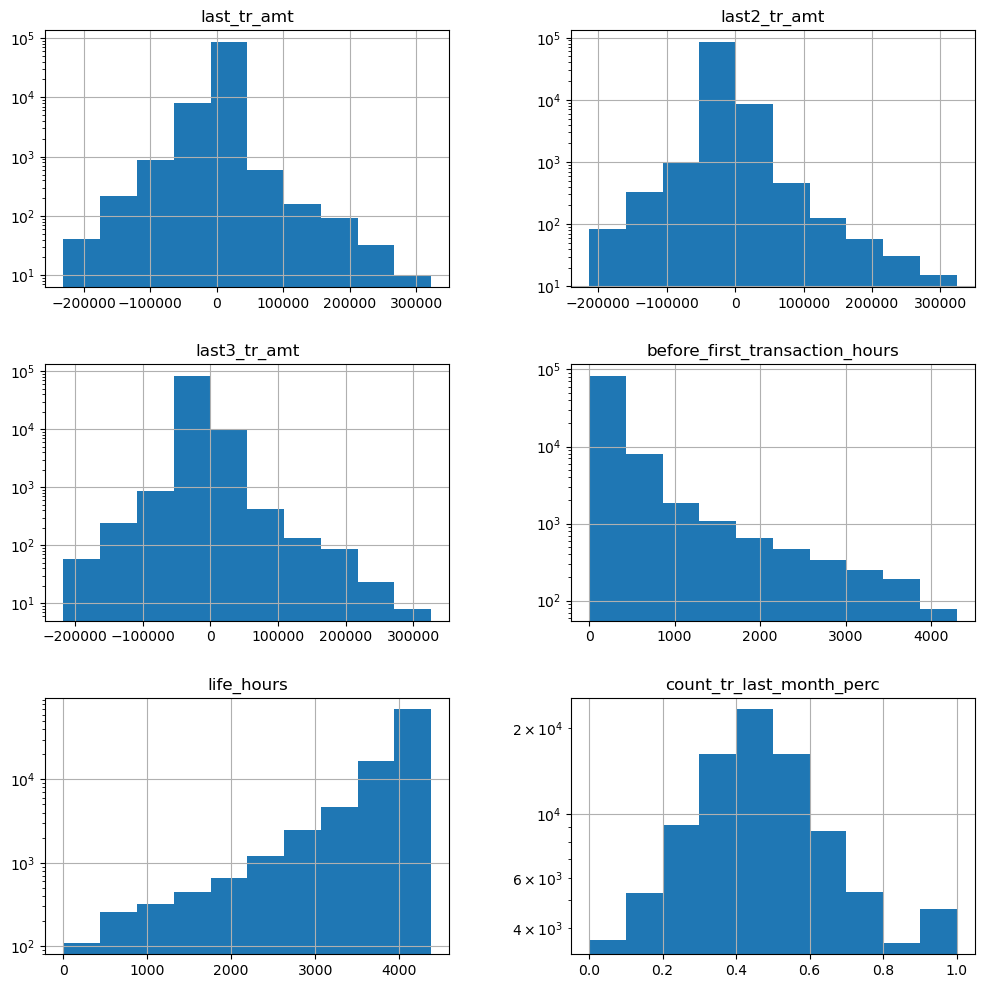

In [11]:
features_full[other_features].hist(figsize=(12,12),log=True);

## Features transformation

In [10]:
REPORT_DURATION_HOURS = 4380
comparable_features_no_transform = ["mean_tr", "med_tr", "qnt10_tr", "qnt90_tr"]
comparable_features_abs_log1p = [
    "sum_neg_tr",
    "mean_neg_tr",
    "med_neg_tr",
    "qnt10_neg_tr",
    "qnt90_neg_tr",
]
comparable_features_log1p = list(
    set(comparable_features)
    - set(comparable_features_no_transform)
    - set(comparable_features_abs_log1p)
)

features_full_prepared = features_full.copy()

features_full_prepared[comparable_features_abs_log1p] = np.log1p(
    np.abs(features_full_prepared[comparable_features_abs_log1p])
)
features_full_prepared[[_ + "_last_month" for _ in comparable_features_abs_log1p]] = np.log1p(
    np.abs(features_full_prepared[[_ + "_last_month" for _ in comparable_features_abs_log1p]])
)

features_full_prepared[comparable_features_log1p] = np.log1p(
    features_full_prepared[comparable_features_log1p]
)
features_full_prepared[[_ + "_last_month" for _ in comparable_features_log1p]] = np.log1p(
    features_full_prepared[[_ + "_last_month" for _ in comparable_features_log1p]]
)

features_full_prepared["before_first_transaction_hours"] = np.log1p(
    features_full_prepared["before_first_transaction_hours"]
)
features_full_prepared["life_hours"] = np.log1p(
    REPORT_DURATION_HOURS - features_full_prepared["life_hours"]
)
features_full_prepared.head()

,user_id,unique_mcc_codes,before_first_transaction_hours,mean_time_diff_tr,med_time_diff_tr,std_time_diff_tr,qnt10_time_diff_tr,qnt90_time_diff_tr,mean_tr,med_tr,...,mean_neg_tr_last_month,med_neg_tr_last_month,std_neg_tr_last_month,count_neg_tr_last_month,qnt10_neg_tr_last_month,qnt90_neg_tr_last_month,unique_days_last_month,mode_mcc_code_last_month,mode_currency_last_month,count_tr_last_month_perc
0,3,1.609438,7.414629,5.546181,5.202703,5.555132,0.327203,6.275797,1246.037876,4549.455078,...,10.671312,9.124403,11.213538,1.609438,11.628495,6.995445,2.197225,0,1,1.000000
1,9,3.135494,1.589292,3.909805,3.133052,4.514225,0.325820,4.972991,-3593.718520,-840.509674,...,8.502820,7.003167,9.583922,4.077537,8.391106,5.569825,3.433987,1,1,0.415309
2,13,1.609438,3.339716,5.264811,5.274204,5.168136,0.494866,6.040453,-5668.971780,-10529.004883,...,9.857946,9.704743,9.667831,2.302585,10.356770,9.162530,2.484907,3,1,0.404959
3,37,3.367296,0.288931,2.686707,1.774081,3.103545,0.262856,3.412906,-1053.522538,-236.420776,...,6.812588,5.407691,8.169992,5.501258,6.865949,4.325181,4.521789,2,1,0.609887
4,41,1.791759,6.485738,5.505866,4.032632,5.749737,0.455806,6.551451,-6786.663385,-6328.293701,...,8.653304,8.653960,8.432449,2.708050,9.389785,6.214204,2.397895,3,1,0.765625


### Histograms

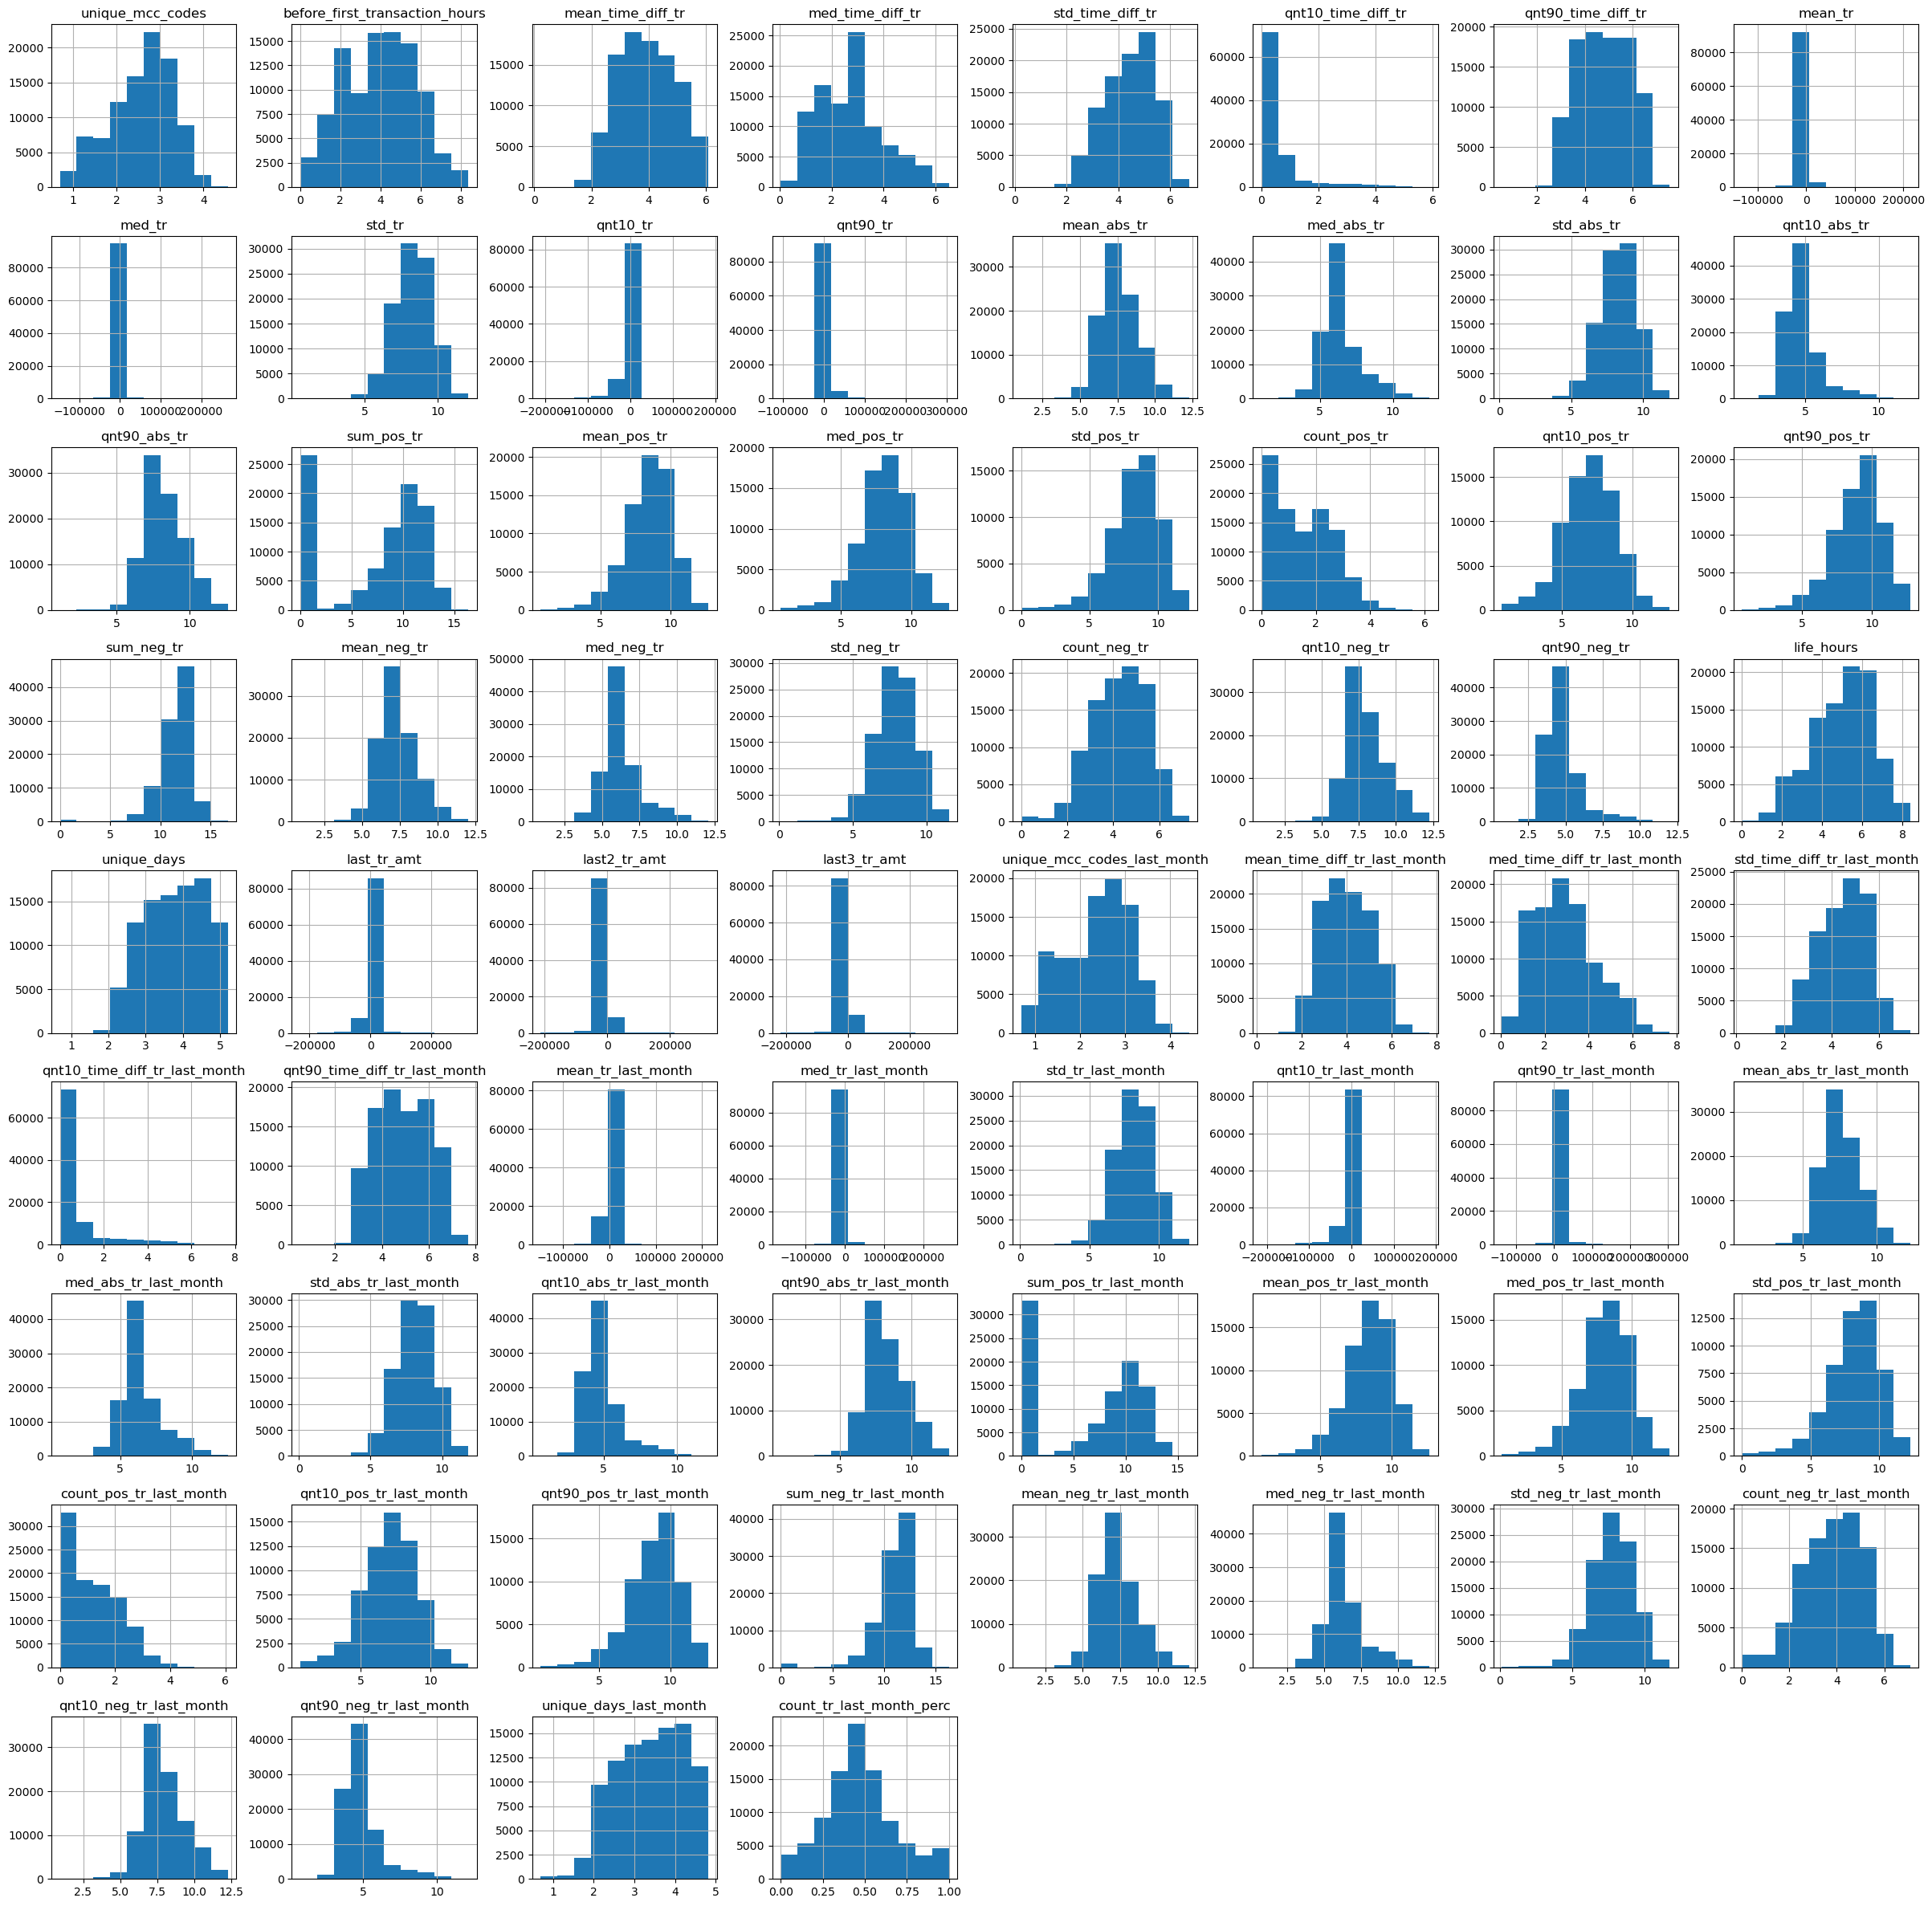

In [31]:
features_full_prepared.drop(columns=(cat_features+["user_id"])).hist(figsize=(30,30));

## Clients information

In [11]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            96000 non-null  int64 
 1   report             96000 non-null  int64 
 2   employee_count_nm  59534 non-null  object
 3   bankemplstatus     96000 non-null  int64 
 4   customer_age       96000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ MB


In [12]:
cat_features += ["report", "employee_count_nm", "bankemplstatus", "customer_age"]
cat_features

['mode_mcc_code',
 'mode_mcc_code_last_month',
 'mode_currency',
 'mode_currency_last_month',
 'report',
 'employee_count_nm',
 'bankemplstatus',
 'customer_age']

In [25]:
full_merged = clients.merge(
    features_full_prepared, how="left", on="user_id", validate="one_to_one"
)
full_merged.replace(
    {
        "employee_count_nm": {
            "ДО 10": 1,
            "ОТ 11 ДО 30": 2,
            "ОТ 11 ДО 50": 3,
            "ОТ 31 ДО 50": 4,
            "ОТ 51 ДО 100": 5,
            "ОТ 101 ДО 500": 6,
            "ОТ 501 ДО 1000": 7,
            "БОЛЕЕ 500": 8,
            "БОЛЕЕ 1001": 9,
        }
    },
    inplace=True,
)
full_merged.fillna(0, inplace=True)
full_merged["employee_count_nm"] = full_merged["employee_count_nm"].astype(int)
full_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 77 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         96000 non-null  int64  
 1   report                          96000 non-null  int64  
 2   employee_count_nm               96000 non-null  int32  
 3   bankemplstatus                  96000 non-null  int64  
 4   customer_age                    96000 non-null  int64  
 5   unique_mcc_codes                96000 non-null  float64
 6   before_first_transaction_hours  96000 non-null  float64
 7   mean_time_diff_tr               96000 non-null  float64
 8   med_time_diff_tr                96000 non-null  float64
 9   std_time_diff_tr                96000 non-null  float64
 10  qnt10_time_diff_tr              96000 non-null  float64
 11  qnt90_time_diff_tr              96000 non-null  float64
 12  mean_tr                         

In [26]:
full_merged.to_csv("data/features_full.csv", index=False)

## One Hot Encoding

In [3]:
full_merged = pd.read_csv("data/features_full.csv")
full_merged

,user_id,report,employee_count_nm,bankemplstatus,customer_age,unique_mcc_codes,before_first_transaction_hours,mean_time_diff_tr,med_time_diff_tr,std_time_diff_tr,...,mean_neg_tr_last_month,med_neg_tr_last_month,std_neg_tr_last_month,count_neg_tr_last_month,qnt10_neg_tr_last_month,qnt90_neg_tr_last_month,unique_days_last_month,mode_mcc_code_last_month,mode_currency_last_month,count_tr_last_month_perc
0,3,2,6,0,3,1.609438,7.414629,5.546181,5.202703,5.555132,...,10.671312,9.124403,11.213538,1.609438,11.628495,6.995445,2.197225,0,1,1.000000
1,9,1,9,0,3,3.135494,1.589292,3.909805,3.133052,4.514225,...,8.502820,7.003167,9.583922,4.077537,8.391106,5.569825,3.433987,1,1,0.415309
2,13,6,7,0,2,1.609438,3.339716,5.264811,5.274204,5.168136,...,9.857946,9.704743,9.667831,2.302585,10.356770,9.162530,2.484907,3,1,0.404959
3,37,5,9,0,2,3.367296,0.288931,2.686707,1.774081,3.103545,...,6.812588,5.407691,8.169992,5.501258,6.865949,4.325181,4.521789,2,1,0.609887
4,41,1,6,0,2,1.791759,6.485738,5.505866,4.032632,5.749737,...,8.653304,8.653960,8.432449,2.708050,9.389785,6.214204,2.397895,3,1,0.765625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,12,0,0,2,2.564949,6.022544,4.424647,3.080705,5.435979,...,6.132442,5.559536,6.412210,2.833213,6.822752,4.305527,2.397895,1,1,0.186998
95996,562205,12,0,0,1,2.772589,4.399676,3.385610,2.834103,3.660827,...,5.772443,4.999273,6.502082,4.663439,6.638332,3.203355,4.110874,11,1,0.492785
95997,562312,12,0,0,0,2.079442,4.444303,4.247610,3.255561,4.928609,...,5.793201,5.653627,5.617553,3.496508,6.380334,3.966319,3.178054,1,1,0.326531
95998,562721,12,0,0,2,2.484907,4.245499,3.931178,3.058714,4.565039,...,8.299842,7.976050,8.395556,3.637586,9.071865,6.020223,3.465736,3,1,0.292872


In [114]:
OHE_features = {
    "mode_mcc_code": "mcc",
    "mode_mcc_code_last_month": "mcc_lm",
    "mode_currency": "curr",
    "mode_currency_last_month": "curr_lm",
}


def custom_combiner(feature, category):
    return str(OHE_features.get(str(feature))) + "_" + str(category)


enc = OneHotEncoder(
    handle_unknown="infrequent_if_exist", min_frequency=50, sparse_output=False, feature_name_combiner=custom_combiner
)
enc.fit(full_merged[OHE_features.keys()])

OneHotEncoder(feature_name_combiner=<function custom_combiner at 0x000001A88E8CEB60>,
              handle_unknown='infrequent_if_exist', min_frequency=50,
              sparse_output=False)

In [115]:
print("Count per each OHE feature:")
[_ for _ in zip(enc.get_feature_names_out(), enc.transform(full_merged[OHE_features.keys()]).sum(axis=0))]

Count per each OHE feature:


[('mcc_0', 8118.0),
 ('mcc_1', 49763.0),
 ('mcc_2', 4757.0),
 ('mcc_3', 10319.0),
 ('mcc_4', 3662.0),
 ('mcc_6', 1263.0),
 ('mcc_7', 965.0),
 ('mcc_8', 239.0),
 ('mcc_9', 1960.0),
 ('mcc_10', 313.0),
 ('mcc_11', 3031.0),
 ('mcc_12', 2648.0),
 ('mcc_13', 275.0),
 ('mcc_14', 962.0),
 ('mcc_15', 147.0),
 ('mcc_16', 53.0),
 ('mcc_17', 785.0),
 ('mcc_18', 61.0),
 ('mcc_19', 391.0),
 ('mcc_20', 205.0),
 ('mcc_21', 154.0),
 ('mcc_22', 73.0),
 ('mcc_26', 1932.0),
 ('mcc_28', 619.0),
 ('mcc_29', 97.0),
 ('mcc_33', 59.0),
 ('mcc_36', 81.0),
 ('mcc_43', 53.0),
 ('mcc_47', 186.0),
 ('mcc_51', 160.0),
 ('mcc_52', 302.0),
 ('mcc_55', 51.0),
 ('mcc_68', 81.0),
 ('mcc_75', 74.0),
 ('mcc_108', 71.0),
 ('mcc_155', 1130.0),
 ('mcc_infrequent_sklearn', 960.0),
 ('mcc_lm_0', 8829.0),
 ('mcc_lm_1', 47532.0),
 ('mcc_lm_2', 4728.0),
 ('mcc_lm_3', 10607.0),
 ('mcc_lm_4', 3728.0),
 ('mcc_lm_6', 1298.0),
 ('mcc_lm_7', 964.0),
 ('mcc_lm_8', 274.0),
 ('mcc_lm_9', 2058.0),
 ('mcc_lm_10', 333.0),
 ('mcc_lm_11', 3019

In [117]:
pd.DataFrame(enc.transform(full_merged[OHE_features.keys()]), columns=enc.get_feature_names_out())

,mcc_0,mcc_1,mcc_2,mcc_3,mcc_4,mcc_6,mcc_7,mcc_8,mcc_9,mcc_10,...,mcc_lm_75,mcc_lm_108,mcc_lm_155,mcc_lm_infrequent_sklearn,curr_0,curr_1,curr_infrequent_sklearn,curr_lm_0,curr_lm_1,curr_lm_infrequent_sklearn
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
95996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
95997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
95998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [123]:
full_merged_with_ohe = full_merged.drop(columns=OHE_features.keys())
full_merged_with_ohe[enc.get_feature_names_out()] = enc.transform(full_merged[OHE_features.keys()])
full_merged_with_ohe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 154 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    user_id                         int64  
 1    report                          int64  
 2    employee_count_nm               int64  
 3    bankemplstatus                  int64  
 4    customer_age                    int64  
 5    unique_mcc_codes                float64
 6    before_first_transaction_hours  float64
 7    mean_time_diff_tr               float64
 8    med_time_diff_tr                float64
 9    std_time_diff_tr                float64
 10   qnt10_time_diff_tr              float64
 11   qnt90_time_diff_tr              float64
 12   mean_tr                         float64
 13   med_tr                          float64
 14   std_tr                          float64
 15   qnt10_tr                        float64
 16   qnt90_tr                        float64
 17   mean_abs_t

# Training

## Cox proportional hazards model

In [124]:
train_merged = train_info.merge(
    full_merged_with_ohe, how="left", on="user_id", validate="one_to_one"
)
train_merged

,user_id,target,time,report,employee_count_nm,bankemplstatus,customer_age,unique_mcc_codes,before_first_transaction_hours,mean_time_diff_tr,...,mcc_lm_75,mcc_lm_108,mcc_lm_155,mcc_lm_infrequent_sklearn,curr_0,curr_1,curr_infrequent_sklearn,curr_lm_0,curr_lm_1,curr_lm_infrequent_sklearn
0,3,0,77,2,6,0,3,1.609438,7.414629,5.546181,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,13,0,86,6,7,0,2,1.609438,3.339716,5.264811,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,0,89,5,9,0,2,3.367296,0.288931,2.686707,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,41,0,57,1,6,0,2,1.791759,6.485738,5.505866,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,42,0,84,12,1,0,3,3.044522,1.512193,4.331025,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,561824,0,91,12,0,0,0,3.367296,4.290459,3.405085,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
63996,562043,0,75,12,0,0,2,2.564949,6.022544,4.424647,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
63997,562312,0,91,12,0,0,0,2.079442,4.444303,4.247610,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
63998,562721,0,29,12,0,0,2,2.484907,4.245499,3.931178,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [125]:
X = train_merged.drop(columns=["user_id", "time"])
y = train_merged.apply(lambda df: (df["target"], df["time"]), axis=1).to_numpy(
    np.dtype([("target", "?"), ("time", "<f8")])
)
y

array([(False, 77.), (False, 86.), (False, 89.), ..., (False, 91.),
       (False, 29.), (False, 91.)],
      dtype=[('target', '?'), ('time', '<f8')])

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22, stratify=X["target"]
)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=22, stratify=X_train["target"]
# )
X_train.drop(columns=["target"], inplace=True)
X_test.drop(columns=["target"], inplace=True)
# X_val.drop(columns=["target"], inplace=True)
print("Train samples {}, test samples {}".format(X_train.shape[0], X_test.shape[0]))

Train samples 51200, test samples 12800


In [135]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.008),
)
coxnet_pipe.fit(X_train, y_train);

In [136]:
score_test = concordance_index(
    y_test[:]["time"], -coxnet_pipe.predict(X_test), y_test[:]["target"]
)
score_train = concordance_index(
    y_train[:]["time"], -coxnet_pipe.predict(X_train), y_train[:]["target"]
)
print(
    "Test concordance index={:.4}, train concordance index={:.4}.".format(
        score_test,
        score_train,
    )
)

Test concordance index=0.7378, train concordance index=0.7528.


## XGBoost

In [9]:
train_merged_no_ohe = train_info.merge(
    full_merged, how="left", on="user_id", validate="one_to_one"
)
y = train_merged_no_ohe.apply(lambda df: (df["target"], df["time"]), axis=1).to_numpy(
    np.dtype([("target", "?"), ("time", "<f8")])
)
X = train_merged_no_ohe.drop(columns=["user_id", "time"])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22, stratify=X["target"]
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=22, stratify=X.iloc[X_train.index]["target"]
)
X_train.drop(columns=["target"], inplace=True)
X_test.drop(columns=["target"], inplace=True)
X_val.drop(columns=["target"], inplace=True)
print("Train samples {}, validation samples {}, test samples {}".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Train samples 40960, validation samples 10240, test samples 12800


In [11]:
cat_features = [
    "mode_mcc_code",
    "mode_mcc_code_last_month",
    "mode_currency",
    "mode_currency_last_month",
    "report",
    "employee_count_nm",
    "bankemplstatus",
    "customer_age",
]

features_types = dict(
    [[x, "category"] if x in cat_features else [x, "float64"] for x in X_train.columns]
)
dtrain = xgb.DMatrix(X_train.astype(features_types), enable_categorical=True)
dtest = xgb.DMatrix(X_test.astype(features_types), enable_categorical=True)
dvalid = xgb.DMatrix(X_val.astype(features_types), enable_categorical=True)

y_lower_bound = y_train["time"]
y_upper_bound = np.where(y_train["target"], y_train["time"], +np.inf)

dtrain.set_float_info("label_lower_bound", y_lower_bound)
dtrain.set_float_info("label_upper_bound", y_upper_bound)

y_lower_bound = y_val["time"]
y_upper_bound = np.where(y_val["target"], y_val["time"], +np.inf)

dvalid.set_float_info("label_lower_bound", y_lower_bound)
dvalid.set_float_info("label_upper_bound", y_upper_bound)

In [19]:
base_params = {
    "verbosity": 0,
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "tree_method": "hist",
}

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.04, 0.1, log=True),
        "aft_loss_distribution": trial.suggest_categorical(
            "aft_loss_distribution", ["normal"] #, "logistic", "extreme"
        ),
        "aft_loss_distribution_scale": trial.suggest_float(
            "aft_loss_distribution_scale", 0.8, 3.0, log=True
        ),
        "max_depth": trial.suggest_int("max_depth", 2, 3),
        "lambda": trial.suggest_float("lambda", 1e-7, 1e-4, log=True),
        "alpha": trial.suggest_float("alpha", 1e-7, 1e-4, log=True),
    } 
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, "valid-aft-nloglik"
    )
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=5,
        verbose_eval=False,
        callbacks=[pruning_callback],
    )
    return bst.best_score

In [20]:
study_bst = optuna.create_study(direction='minimize')
study_bst.optimize(objective, n_trials=200)
print('Completed hyperparameter tuning with best aft-nloglik = {}.'.format(study_bst.best_trial.value))

[I 2024-04-15 20:13:33,043] A new study created in memory with name: no-name-dfb67c59-94ed-40f4-8a9f-3878e5d8d3dc
[I 2024-04-15 20:13:34,035] Trial 0 finished with value: 0.6264836427673535 and parameters: {'learning_rate': 0.05079396541823434, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 1.6995923681547804, 'max_depth': 2, 'lambda': 7.785273023393326e-05, 'alpha': 7.458041708154182e-05}. Best is trial 0 with value: 0.6264836427673535.
[I 2024-04-15 20:13:35,072] Trial 1 finished with value: 0.6237483143454164 and parameters: {'learning_rate': 0.0793136295008985, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 1.274009235014162, 'max_depth': 3, 'lambda': 5.2986635047354455e-05, 'alpha': 3.2273894902037864e-05}. Best is trial 1 with value: 0.6237483143454164.
[I 2024-04-15 20:13:36,169] Trial 2 finished with value: 0.622854118799059 and parameters: {'learning_rate': 0.08780311439798866, 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scal

Completed hyperparameter tuning with best aft-nloglik = 0.622854118799059.


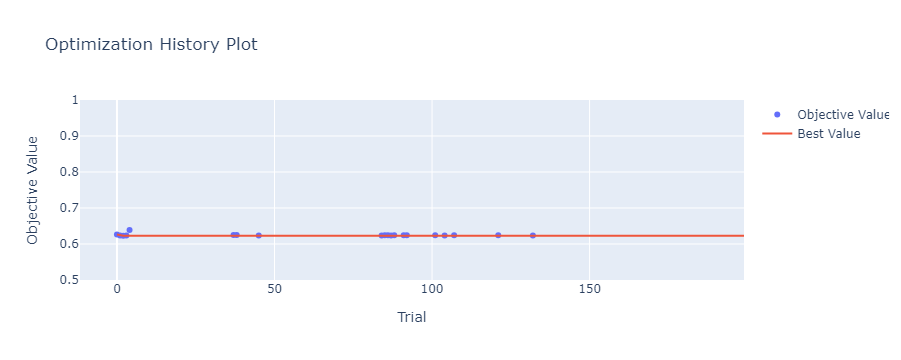

In [21]:
fig = optuna.visualization.plot_optimization_history(study_bst)
fig.update_layout(yaxis_range=[0.5, 1])

In [32]:
# params = {}
# params.update(base_params)
# params.update(study_bst.best_trial.params)
# params.update({'verbosity': 1})
params = {
    "verbosity": 1,
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "tree_method": "hist",
    "learning_rate": 0.0878,
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": 1.327,
    "max_depth": 3,
    "lambda": 1.7e-07,
    "alpha": 1.8e-6,
}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=5,
)

[0]	train-aft-nloglik:8.32238	valid-aft-nloglik:8.33672
[1]	train-aft-nloglik:7.14354	valid-aft-nloglik:7.15648
[2]	train-aft-nloglik:6.15287	valid-aft-nloglik:6.16412
[3]	train-aft-nloglik:5.31929	valid-aft-nloglik:5.32888
[4]	train-aft-nloglik:4.61701	valid-aft-nloglik:4.62535
[5]	train-aft-nloglik:4.02444	valid-aft-nloglik:4.03202
[6]	train-aft-nloglik:3.52374	valid-aft-nloglik:3.53023
[7]	train-aft-nloglik:3.09993	valid-aft-nloglik:3.10574
[8]	train-aft-nloglik:2.74075	valid-aft-nloglik:2.74604
[9]	train-aft-nloglik:2.43584	valid-aft-nloglik:2.44059
[10]	train-aft-nloglik:2.17662	valid-aft-nloglik:2.18090
[11]	train-aft-nloglik:1.95590	valid-aft-nloglik:1.95976
[12]	train-aft-nloglik:1.76774	valid-aft-nloglik:1.77115
[13]	train-aft-nloglik:1.60705	valid-aft-nloglik:1.61023
[14]	train-aft-nloglik:1.46965	valid-aft-nloglik:1.47258
[15]	train-aft-nloglik:1.35201	valid-aft-nloglik:1.35473
[16]	train-aft-nloglik:1.25120	valid-aft-nloglik:1.25371
[17]	train-aft-nloglik:1.16470	valid-aft-

In [35]:
train_y_pred = bst.predict(dtrain)
test_y_pred = bst.predict(dtest)
val_y_pred = bst.predict(dvalid)

ci_train = concordance_index(y_train['time'], train_y_pred, y_train['target'])
ci_val = concordance_index(y_val['time'], val_y_pred, y_val['target'])
ci_test = concordance_index(y_test['time'], test_y_pred, y_test['target'])
print(f'Test Concordance index={ci_test:0.4f}')
print(f'Valid Concordance index={ci_val:0.4f}')
print(f'Train Concordance index={ci_train:0.4f}')

Test Concordance index=0.7510
Valid Concordance index=0.7565
Train Concordance index=0.8077


# Submit saving

In [227]:
x_test_sample = sample.merge(
    full_merged, how="left", on="user_id", validate="one_to_one"
).drop(columns=["user_id", "predict"])


dtest_sample = xgb.DMatrix(
    x_test_sample.astype(features_types), enable_categorical=True
)
sample_y_pred = bst.predict(dtest_sample)
sample_y_pred

array([8353.25  , 2427.2927, 4370.048 , ..., 3533.351 , 1514.5969,
       2167.6086], dtype=float32)

In [228]:
sample["predict"] = sample_y_pred
sample.to_csv("submit.csv", index=False)